# Analyze results of  $\rm K Er Se_2$ "loopthrough" where we found the range of Hamiltonians within one standard deviation in $\chi^2$

Allen Scheie

December 2019

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
import sys

import plotformat as pf
import PyCrystalField as cef
from pythonlib.MsliceData import mslice



## Import all the data
data1p6K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_1p6K.txt', unpack=True)
data15K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_15K.txt', unpack=True)
data100K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_100K.txt', unpack=True)

alldata = [data1p6K,data15K,data100K]
datatemps = [1.8, 15, 100]

<IPython.core.display.Javascript object>


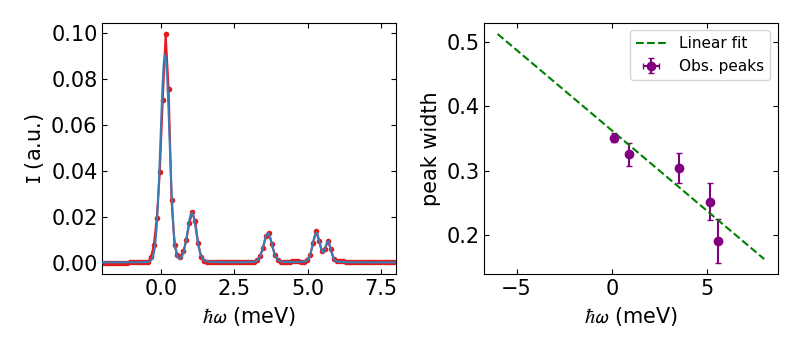

[0.13515156487106053, 0.9132071732842264, 3.504800645878369, 5.155917342976868, 5.560145541287389] [0.3512410705480638, 0.3253514112153624, 0.3043522834245795, 0.25200588513890115, 0.1910902208311937] 0.061315245063475
[-0.0249575   0.36262711]


In [2]:
## Pick out observed eigenvalues
from scipy.special import wofz


def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = alldata[0][0], alldata[0][1], alldata[0][2]

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.00015

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.00015

p0 = [4e-2, 0.15,0.25, 9e-3,0.87,0.25, 5e-3,3.47,0.25, 5e-3,5.11,0.18, 4e-3,5.58,0.18, 0.1, 0.1]

poptinitial, pcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *poptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
ObsEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObsWidths, DOW = [poptinitial[3*i+2] for i in range(0,5)],    [uncinitial[3*i+2] for i in range(0,5)]
print(ObsEnergies, ObsWidths, poptinitial[-1])
fittedLW = poptinitial[-1]

ax[1].errorbar(ObsEnergies, ObsWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
# width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
width_popt, width_pcov = curve_fit(straightline, ObsEnergies[1:], ObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(width_popt)

<IPython.core.display.Javascript object>


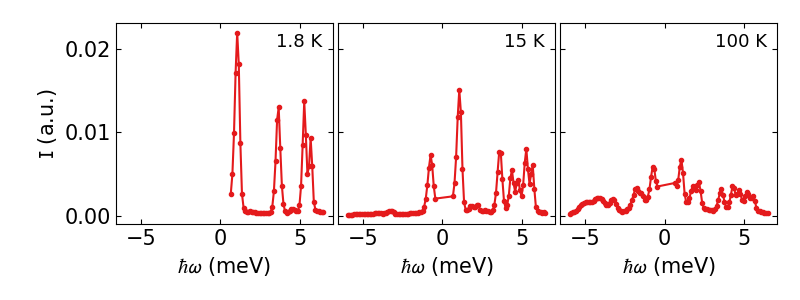

In [3]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

fitdata = deepcopy(alldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(fitdata)):
    fitdata[i] = np.hstack((fitdata[i][:,40:96], fitdata[i][:,106:-15]))
    
fitdata[0] = fitdata[0][:,56:]
    
f, ax = plt.subplots(1,3, figsize=(8,3), sharex=True, sharey=True)
for i,data in enumerate(fitdata):
    ax[i].errorbar(data[0], data[1], data[2], marker='.')
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.02)

## Define global Chi2

In [4]:
FitCoefRes1a, FitCoefRes2a = np.load('KES_bestfitcoeff.npy', allow_pickle=True)

# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]


Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )

        
Er = cef.CFLevels(Er_O, FitCoefRes1a['coeff'])
Er.diagonalize()

######################

xoffset = ObsEnergies[0]+0.02
ObservedEnergies = [0]+ObsEnergies[1:]+[np.nan,np.nan, np.nan]

def err_global_final(CFLevelsObject, coeff, gammas, xoff, pref, bkg, thermexp):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data[0]*(1+datatemps[i]*thermexp)-xoff,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gammas[i]) )+\
                        bkg[i] -data[1]
                
        erro += np.nansum((errspec/data[2])**2)
        
#     # Compute error in susceptibility
#     calcchi_ab = -1/CFLevelsObject.susceptibility(ion, MT_abT, [1,0,0], 0.001)[:,0]
#     calcchi_c  = -1/CFLevelsObject.susceptibility(ion, MT_abT,  [0,0,1], 0.001)[:,2]
#     erro += (np.sum((calcchi_ab/calcchi_c - ChiRatio)**2))*1e2
    
    
    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

err_global_final(Er, coeff = FitCoefRes1a['coeff'], gammas=FitCoefRes1a['gammas'], 
                        pref=FitCoefRes1a['pref'], xoff = FitCoefRes1a['xoff'], bkg=FitCoefRes1a['bkg'], 
                          thermexp=FitCoefRes1a['thermexp'])

 err = 16710.614721427504    

16710.614721427504

# Compare the different best fit coefficients

In [5]:
bestfitline = np.load('KES_loopthrough_bestfitline.npy',  allow_pickle=True)

# Analyze output

In [7]:
for i in range(len(bestfitline[0])):
    bflcoeff = bestfitline[1:7, i]

    newH = np.sum([a*b for a,b in zip(Er.O, bflcoeff)], axis=0)
    Er.diagonalize_banded(newH)
    print(bestfitline[-1,i], '\t', Er.eigenvectors[0][7:9],'\t', Er.eigenvectors[1][7:9])

30.945529674714003 	 [0.58327519 0.        ] 	 [ 0.         -0.58327519]
31.11561315944516 	 [ 0.         -0.59400704] 	 [0.59400704 0.        ]
31.62050014060629 	 [ 0.         -0.60468633] 	 [0.60468633 0.        ]
32.47314228023045 	 [0.61531432 0.        ] 	 [ 0.         -0.61531432]
33.63300830253104 	 [ 0.         -0.62589332] 	 [0.62589332 0.        ]
32.45992138875212 	 [ 0.         -0.61533664] 	 [0.61533664 0.        ]
31.662221345679967 	 [0.60471881 0.        ] 	 [ 0.         -0.60471881]
31.11613893030504 	 [ 0.         -0.59400664] 	 [0.59400664 0.        ]
30.945529674713967 	 [ 0.         -0.58327519] 	 [0.58327519 0.        ]
31.11374672055867 	 [0.57247667 0.        ] 	 [ 0.         -0.57247667]
31.615722305173644 	 [0.561625 0.      ] 	 [ 0.       -0.561625]
32.4558779158985 	 [-0.55069276  0.        ] 	 [ 0.         -0.55069276]


In [8]:
numfreeparams = len(np.hstack(([alldata[i][0] for i in range(len(alldata))]))) - 16

## Loop through best fit line and calculate chi2 for many points
for i in range(len(bestfitline[0])):
    print(err_global_final(Er, bestfitline[1:7, i],  gammas = bestfitline[7:10, i], 
                       xoff= bestfitline[10, i], pref=bestfitline[0, i], 
                        thermexp=bestfitline[11, i], bkg=FitCoefRes1a['bkg'])/ numfreeparams)

 err = 16710.58602434556    31.890431344170917
 err = 16802.431106100386    32.06570821774883
 err = 17075.070075927397    32.58601159528129
 err = 17535.496831324443    33.46468860939779
 err = 18161.82448336676    34.659970388104504
 err = 17528.357549926146    33.45106402657662
 err = 17097.59952666718    32.62900673028088
 err = 16802.715022364722    32.06625004268077
 err = 16710.586024345543    31.89043134417088
 err = 16801.42322910168    32.063784788361986
 err = 17072.49004479377    32.58108787174383
 err = 17526.17407458519    33.446897088903036


 err = 17236.498364057097    time = 1.8650107383728027


<IPython.core.display.Javascript object>


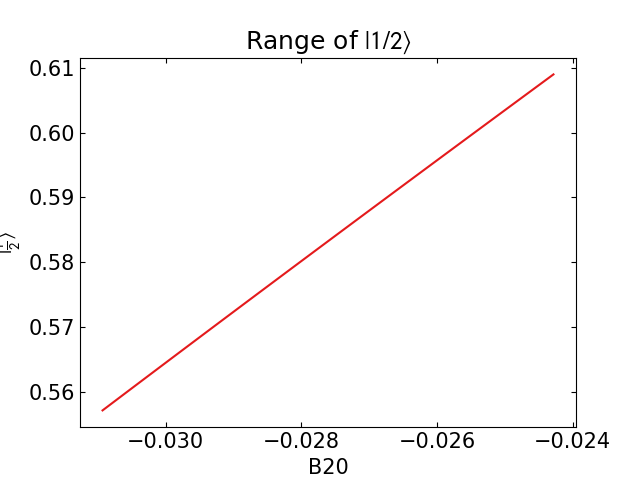

mean J=1/2: 0.5831698093743831 pm 0.02592914329931273


In [35]:
import scipy.linalg as LA
import scipy.sparse.linalg as SLA


def curvedline(x,a,b, c):
    return a*x + b + c*x**2

ll = 0
popt, pcov = [], []
for i in range(len( bestfitline)):
    popt0, pcov0 = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[i][ll:])
    popt.append(popt0)
    pcov.append(pcov0)


def bestfitCoeff(B20):
    bfc = []
    for i in range(len( bestfitline)):
        bfc.append( curvedline(B20, *popt[i]))
    return bfc
            
def findbands(matrix):
    diag = np.diag(matrix)
    band1 = [matrix[i,i+3] for i in range(len(matrix)-3)] + [0]*3
    band2 = [matrix[i,i+6] for i in range(len(matrix)-6)] + [0]*6
    return np.array([diag,[0]*len(matrix),[0]*len(matrix), band1,[0]*len(matrix),[0]*len(matrix), band2])
    
from time import time
starttime = time()
    
B20array = np.linspace(-0.03093, -0.024284, 100)
# B20array = np.linspace(-0.04, -0.039, 20)
B20array_chi2 = []
j0p5weights = []
for i, B20 in enumerate(B20array):
    cf = bestfitCoeff(B20)
    B20array_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:10], 
                       xoff= cf[10], pref=cf[0], 
                        thermexp=cf[11], bkg=FitCoefRes1a['bkg'])/ numfreeparams)
    
    newH = np.sum([a*b for a,b in zip(Er.O, cf[1:7])], axis=0)
    Er.diagonalize_banded(newH)
    j0p5weights.append(np.max(np.abs(Er.eigenvectors[0][7:9])))
    
print('time =',time()-starttime)
    
plt.figure()
plt.plot(B20array, j0p5weights)
plt.xlabel('B20')
plt.ylabel('$|\\frac{1}{2} \\rangle$')
plt.title('Range of $| 1/2 \\rangle$')

print('mean J=1/2:', np.mean(j0p5weights), 'pm', (np.max(j0p5weights)-np.min(j0p5weights))/2)

<IPython.core.display.Javascript object>


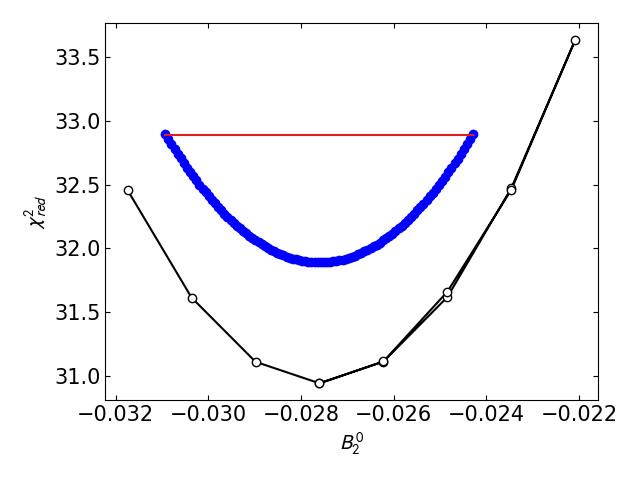

In [37]:
## The number of free parameters was incorrectly defined previously, hence the different magnitude of chi^2

chisqstyle = {'marker':'o'}

plt.figure()
plt.plot(bestfitline[1], bestfitline[-1], color='k', marker='o', mfc='w')
plt.plot(B20array, B20array_chi2, color='b',  **chisqstyle)
plt.plot(B20array[np.array([0,-1])], [np.min(B20array_chi2)+1,np.min(B20array_chi2)+1])
plt.ylabel('$\\chi^2_{red}$')
#ax2.set_ylim(0,)
plt.xlabel('$B_2^0$')
plt.tight_layout()

In [14]:
## Import magnetization

MHdata = np.genfromtxt('KErSe2_bulkdata/mh.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

Na = 6.02214076e23 
SCF = 1/(1.07828221e24/Na)
# import susceptibility
rawKESMTdata = np.genfromtxt('KErSe2_bulkdata/MT.dat', 
                       delimiter='\t', unpack=True, skip_header=2, skip_footer=1263-542)
## Take some averages because it is TOO many data points
MTdata = []
for i in range(len(rawKESMTdata)):
    MTdata.append(np.nanmean(rawKESMTdata[i].reshape(-1,3), axis=1))


Mtemp = 2
fieldstrengths = np.arange(0,7.1,0.1)
magnetization = np.zeros((len(fieldstrengths), 3, 3))
netmag = np.zeros(len(fieldstrengths))

## Import processed magnetization at 2 K

KES_MT_2 = np.genfromtxt('KErSe2_bulkdata/'+\
           'RE__CsErSe2_heat_capacity_and_magnetization_results/KES_Magnetization.txt')





model1color= pf.adjustlightness(pf.cpal1[2], 0.3)#'k'
model2color= pf.adjustlightness(pf.cpal1[0], 0.3)
KEScolor = np.array([0,0,0,1]) # pf.adjustlightness(pf.cpal1[1], 0.5)
CEScolor = np.array([0,0,0,1]) #pf.adjustlightness(pf.cpal1[3], 0.1, False)
# dataprops = {'ls':'-','marker':'o', 'ms':4, 'mew':1,'color':'k', 'label':'data'}
KESdataprops = {'ls':'-','marker':'.','color':KEScolor, 'label':'data'}
CESdataprops = {'ls':'-','marker':'.','color':CEScolor, 'label':'data'}


CESab_data = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor, 0.5, False), 'markersize':4}
CESc_data = {'marker':'s', 'ls':'none', 'color':CEScolor, 'markersize':4}
CESpow_data = {'marker':'s', 'ls':'none','color':CEScolor, 'markersize':4}


KESab_dataM = {'marker':'o', 'ls':'none', 'mfc':'w', 'mec':  pf.adjustlightness(KEScolor, 0.8)}
KESc_dataM = {'marker':'o', 'ls':'none', 'color':KEScolor, 'mec':pf.adjustlightness(KEScolor, 0.8)}

CESab_dataM = {'marker':'s', 'ls':'none', 'mfc':'w', 'mec':pf.adjustlightness(CEScolor, 0.5)}
CESc_dataM = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor,0.2,False), 
          'mec':pf.adjustlightness(CEScolor, 0.5)}


<IPython.core.display.Javascript object>


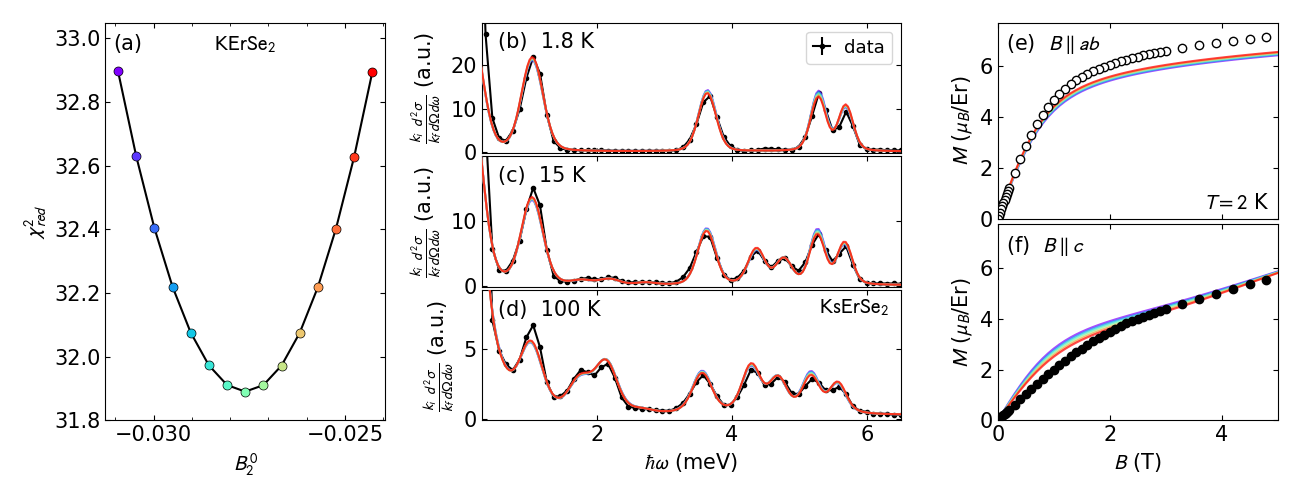

 err = 17236.498364057097    

In [15]:

#######################################################################

fig2 = plt.figure(figsize=(13,5))
outer = gridspec.GridSpec(1,3, figure=fig2, width_ratios=[1,1.5,1])
gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[1], hspace=0.03)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2], hspace=0.03)

ax0 = fig2.add_subplot(outer[0])
ax = [fig2.add_subplot(gs0[i]) for i in range(3)]
ax2 = [fig2.add_subplot(gs1[i]) for i in range(2)]
# ax3 = fig2.add_subplot(outer[3])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax2[0].get_xticklabels(), visible=False)

xxx = np.linspace(-10,30,1200)

B20values = np.linspace(np.min(B20array), np.max(B20array), 6)
# B20colors = plt.cm.bwr(np.linspace(0,1,len(B20values)))
B20colors = plt.cm.rainbow(np.linspace(0,1,len(B20values)))

sf=1e3


plotted_chi2 = []
    
#     for j,Bopt in enumerate(bestfitline.T):
for j,B20 in enumerate(B20values):
    cf = bestfitCoeff(B20)
    Er = cef.CFLevels(Er_O, cf[1:7])
    Er.diagonalize()

#     plotted_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:9], 
#                        xoff= cf[9], pref=cf[0], 
#                         thermexp=cf[10], bkgscale=[1,1])/ numfreeparams)
    
    for i,data in enumerate(alldata):
        if j == 0 :
            ax[i].errorbar(data[0], sf*data[1], sf*data[2],  **KESdataprops)

        
        ax[i].plot(xxx, sf*(bestfitline[0][j]*Er.normalizedNeutronSpectrum(
                        Earray=xxx*(1+datatemps[i]*cf[11]) - cf[10], 
                            Temp=datatemps[i], ResFunc=lambda de: straightline(de,*width_popt),  
                                    gamma=cf[7:10][i]) + FitCoefRes1a['bkg'][i]), 
                            zorder=10, color=B20colors[j], alpha=0.7)

    ## compute and plot magnetizaiton
    for ii, fs in enumerate(fieldstrengths):
        magnetization[ii,0] = Er.magnetization(ion, Mtemp, [fs,0,0])
        magnetization[ii,1] = Er.magnetization(ion, Mtemp, [0,fs,0])
        magnetization[ii,2] = Er.magnetization(ion, Mtemp, [0,0,fs])

    ax2[0].plot(fieldstrengths, -magnetization[:,0,0], color=B20colors[j], alpha=0.7)
    ax2[1].plot(fieldstrengths, -magnetization[:,2,2], color=B20colors[j], alpha=0.7)


################
# Plot chi2

B20values2 = np.linspace(np.min(B20array), np.max(B20array), 15)
B20colors2 = plt.cm.rainbow(np.linspace(0,1,len(B20values2)))

for j,B20 in enumerate(B20values2):
    cf = bestfitCoeff(B20)
    Er = cef.CFLevels(Er_O, cf[1:7])
    Er.diagonalize()

    plotted_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:10], 
                       xoff= cf[10], pref=cf[0], 
                        thermexp=cf[11], bkg=FitCoefRes1a['bkg'])/ numfreeparams)
    ax0.plot(B20, plotted_chi2[j], marker='o', ms=5, color=B20colors2[j])
ax0.plot(B20values2, plotted_chi2, marker='o',color='k',mfc='none', zorder=-1)
ax0.set_ylabel('$\\chi^2_{red}$')
#ax2.set_ylim(0,)
ax0.set_xlabel('$B_2^0$')
ax0.text(0.03,0.97, '(a)', transform=ax0.transAxes,
              verticalalignment='top', horizontalalignment='left')
ax0.text(0.5,0.97, '$\\rm KErSe_2$', transform=ax0.transAxes,
              verticalalignment='top', horizontalalignment='center')
ax0.set_ylim(31.8,33.05)
ax0.xaxis.set_major_locator(MultipleLocator(0.005))
ax0.xaxis.set_minor_locator(MultipleLocator(0.001))

################

        
for i in range(len(ax)):
    # ax[i].set_xlim(-6,8)
    ax[i].set_xlim(0.3,6.5)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
    ax[i].set_ylabel('$\\frac{k_i}{k_f} \\frac{d^2 \sigma}{d \\Omega d \\omega}$ (a.u.)')



ax[0].set_ylim(-0.1,29.9)
ax[1].set_ylim(-0.1,19.9)
ax[2].set_ylim(-0.1,9.2)
ax[0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)

subplotlabels = 'abcdefghijk'
for i, axx in enumerate(ax):
    axx.text(0.04,0.93, '('+subplotlabels[i+1]+')  '+str(datatemps[i])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    
ax2labels = ['$B \\parallel ab$', '$B \\parallel c$']
for i, axx in enumerate(ax2):
    axx.text(0.03,0.95, '('+subplotlabels[i+4]+')  '+ax2labels[i], transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')

ax[-1].text(0.97,0.95, '$\\rm KsErSe_2$', transform=ax[-1].transAxes,
              verticalalignment='top', horizontalalignment='right')
ax[-1].xaxis.set_major_locator(MultipleLocator(2))


############################# Plot magnetization

ax2[0].plot(KES_MT_2[0],KES_MT_2[1],label='data ($B \\parallel ab$)', **KESab_dataM)
ax2[1].plot(KES_MT_2[2],KES_MT_2[3],label='data ($B \\parallel c$)', **KESc_dataM)

ax2[-1].set_xlabel('$B$ (T)')
for i in range(2):
    ax2[i].set_ylabel('$M$ ($\mu_B$/Er)')
    ax2[i].set_xlim(0,5)
    ax2[i].set_ylim(0,7.7)

# ax2[0].text(1.2,6.9,)
# ax2[1].text(1.2,6.9,)
ax2[0].text(0.97,0.03,'$T=2$ K', transform=ax2[0].transAxes, verticalalignment='bottom',
           horizontalalignment='right')
    
plt.tight_layout()

pf.replace_zeros()

# Get uncertanties of CEF eigenvalues and eigenvectors

In [16]:
len(popt)

13

In [17]:
def curvedline(x,a,b, c):
    return a + b*x + c*x**2

popt, pcov = [], []
for i in range(len(bestfitline)):
    popt0, pcov0 = curve_fit(curvedline, bestfitline[1][:], bestfitline[i][:])
    popt.append(popt0)
    pcov.append(pcov0)

    

labels = ['scale factor','$B_2^0$','$B_4^0$','$B_4^3$','$B_6^0$','$B_6^3$','$B_6^6$',
         '$LW_{\\rm 1.8\\>K}$', '$LW_{\\rm 15\\>K}$', '$LW_{\\rm 100\\>K}$', '$\hbar \omega$ offset', 
          'therm, expan.', '$\\chi^2$']


print('\\begin{table}\n\\caption{Best fit curve through parameter space for $\\rm KErSe_2$,'+\
      ' where variable$=a + b (B_2^0) + b (B_2^0)^2 $}')
print('\\begin{ruledtabular}')
numpar = 3
print('\\begin{tabular}{c|'+'c'*numpar+'}')
print('Variable & a & b & c  \\tabularnewline\n \\hline ')

for i in range(len(bestfitline)-1):
    punci =  np.sqrt(np.diag(pcov[i]))
    strpopt = []
    for j in range(3):
        fnz = -(int(np.log10(punci[j]))-1) # first non-zero in uncertainty
        if fnz > 0:
            newstring = str(np.around(popt[i][j], fnz))+'('+str(np.around(punci[j],fnz))[-1]+')'
            if 'e' in newstring:
                splitstring = newstring.split('e-0')
                newstring = splitstring[0]+splitstring[1][-3:] + '$\\times 10^{-' +splitstring[1][:-3]+ '}$'
                strpopt.append(newstring)
            else:
                strpopt.append(newstring)
        else:
            fnz = -int(np.log10(punci[j]))
            strpopt.append(str(int(np.around(popt[i][j], fnz)))+'('+str(int(np.around(punci[j],fnz)))+')')
    if i != 1:
        print(labels[i],' &\t', ' & \t'.join(strpopt), ' \\tabularnewline')
        
print('\\end{tabular}\\end{ruledtabular}')
print('\\label{flo:KES_bestfitline}\n\\end{table}')

\begin{table}
\caption{Best fit curve through parameter space for $\rm KErSe_2$, where variable$=a + b (B_2^0) + b (B_2^0)^2 $}
\begin{ruledtabular}
\begin{tabular}{c|ccc}
Variable & a & b & c  \tabularnewline
 \hline 
scale factor  &	 0.0005137(7) & 	-0.00134(5) & 	-0.017(1)  \tabularnewline
$B_4^0$  &	 -0.0004389(7) & 	-0.00127(5) & 	0.0066(5)  \tabularnewline
$B_4^3$  &	 -0.0124(5) & 	0.074(2) & 	0.38(3)  \tabularnewline
$B_6^0$  &	 2.996(9)$\times 10^{-6}$ & 	-5.7(7)$\times 10^{-6}$ & 	-4(6)$\times 10^{-6}$  \tabularnewline
$B_6^3$  &	 -2.67(8)$\times 10^{-5}$ & 	-0.000809(6) & 	-0.00435(5)  \tabularnewline
$B_6^6$  &	 1.58(7)$\times 10^{-5}$ & 	-0.00065(5) & 	-0.0013(2)  \tabularnewline
$LW_{\rm 1.8\>K}$  &	 0.06(5) & 	-0.1(4) & 	0.7(9)  \tabularnewline
$LW_{\rm 15\>K}$  &	 0.08(1) & 	0.7(1) & 	20(20)  \tabularnewline
$LW_{\rm 100\>K}$  &	 0.13(4) & 	-0.5(1) & 	-10(60)  \tabularnewline
$\hbar \omega$ offset  &	 0.149(4) & 	-0.0(3) & 	-6.8(2)  \tabularnewline
therm, expan.  &	 0.00

In [30]:
def bestfitCoeff(B20):
    bfc = []
    for i in range(len( bestfitline)):
        bfc.append( curvedline(B20, *popt[i]))
    return bfc
            
def findbands(matrix):
    diag = np.diag(matrix)
    band1 = [matrix[i,i+3] for i in range(len(matrix)-3)] + [0]*3
    band2 = [matrix[i,i+6] for i in range(len(matrix)-6)] + [0]*6
    return np.array([diag,[0]*len(matrix),[0]*len(matrix), band1,[0]*len(matrix),[0]*len(matrix), band2])
    
    
    
B20array = np.linspace(-0.03093, -0.024284, 3)
BestFitBvalues = []
B20array_chi2 = []
j0p5weights = []
RangeEvals = []
RangeEvecs = []
for i, B20 in enumerate(B20array):
    cf = bestfitCoeff(B20)
    BestFitBvalues.append(cf[1:7])
    B20array_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:10], 
                       xoff= cf[10], pref=cf[0], 
                        thermexp=cf[11], bkg=FitCoefRes1a['bkg'])/ numfreeparams)
    
    newH = np.sum([a*b for a,b in zip(Er.O, cf[1:7])], axis=0)
#     print(newH)
    bands = findbands(newH)
    diagonalH = LA.eig_banded(bands, lower=True)
    eigenvectors = diagonalH[1].T
#     print('\n', eigenvectors[0],'\n', eigenvectors[1],'\n')
    nnn = 14
    print('\n', np.around(eigenvectors[nnn],5),'\n', np.around(eigenvectors[nnn+1],5),'\n')
    RangeEvals.append(diagonalH[0] - np.min(diagonalH[0]))
    if i == 0:
        RangeEvecs.append([eigenvectors[1], eigenvectors[0],
                           eigenvectors[2],-eigenvectors[3],
                           eigenvectors[5],-eigenvectors[4],
                           eigenvectors[6], eigenvectors[7],
                           eigenvectors[8], eigenvectors[9],
                          eigenvectors[10], eigenvectors[11],
                          eigenvectors[13],-eigenvectors[12],
                          eigenvectors[14], eigenvectors[15]])
    elif i == 1:
        RangeEvecs.append(eigenvectors)
    elif i == 2:
        RangeEvecs.append([eigenvectors[1], eigenvectors[0],
                           eigenvectors[2],-eigenvectors[2],
                           eigenvectors[4],-eigenvectors[5],
                          -eigenvectors[7], eigenvectors[6],
                          eigenvectors[9], eigenvectors[8],
                          eigenvectors[11],eigenvectors[10],
                          eigenvectors[13], eigenvectors[12],
                          eigenvectors[14], eigenvectors[15]])
        

RangeEvecs = np.array(RangeEvecs)
RangeEvals = np.array(RangeEvals)

# print('mean J=1/2:', np.mean(j0p5weights), 'pm', (np.max(j0p5weights)-np.min(j0p5weights))/2)




 err = 17237.732735141086    
 [ 0.       0.      -0.33301  0.       0.      -0.46843  0.       0.
  0.1328   0.       0.      -0.73489  0.       0.       0.33463  0.     ] 
 [ 0.      -0.33463  0.       0.      -0.73489  0.       0.      -0.1328
  0.       0.      -0.46843  0.       0.       0.33301  0.       0.     ] 

 err = 16710.67332502323    
 [ 0.       0.      -0.33103  0.       0.      -0.45507  0.       0.
  0.13378  0.       0.      -0.73921  0.       0.       0.34496  0.     ] 
 [ 0.      -0.34496  0.       0.      -0.73921  0.       0.      -0.13378
  0.       0.      -0.45507  0.       0.       0.33103  0.       0.     ] 

 err = 17236.498364057097    
 [ 0.       0.      -0.32776  0.       0.      -0.44029  0.       0.
  0.1348   0.       0.      -0.74415  0.       0.       0.35608  0.     ] 
 [ 0.      -0.35608  0.       0.      -0.74415  0.       0.      -0.1348
  0.       0.      -0.44029  0.       0.       0.32776  0.       0.     ] 



In [31]:
def stringify_uncertainty(value, uncertainty):
    try:
        fnz = -(int(np.log10(uncertainty))-1) # first non-zero in uncertainty
        if fnz > 0:
            newstring = str(np.around(value, fnz))+'('+str(np.around(uncertainty,fnz))[-1]+')'
            if 'e' in newstring:
                splitstring = newstring.split('e-')
                newstring = splitstring[0]+splitstring[1][-3:] + '$\\times 10^{-' +splitstring[1][:-3]+ '}$'
        else:
            newstring = str(np.around(value, fnz))+'('+str(np.around(uncertainty,fnz))[0]+')'
        return newstring
    except OverflowError:
        return str(np.around(value,1))

'''for every eigenvalue, print the nonzero weights'''
print('\n')


print('\\begin{table*}\n\\caption{Eigenvectors and Eigenvalues for $\\rm KErSe_2$}')
print('\\begin{ruledtabular}')
numwt = 7
print('\\begin{tabular}{c|'+'r'*numwt+'}')
print('Eigenvalues (meV) & '+'& '*(numwt-1) + 'Eigenvectors' +' \\tabularnewline\n \\hline ')

nmatrix = 15
kk = np.arange(-nmatrix, nmatrix+1, 2)
for i in range(nmatrix+1):
    EVvalue = stringify_uncertainty(np.around(RangeEvals[1][i],10), 
                                    np.abs(RangeEvals[1][i]-RangeEvals[0][i]))

    
    EV_nonzero_list = []
    for j in range(nmatrix+1):
        # Find fractional value
        if kk[j] < 0:
            frac = '| - \\frac{'+str(abs(kk[j]))+'}{2}\\rangle $'
        else:
            frac = '| \\frac{'+str(abs(kk[j]))+'}{2}\\rangle $'
        
        #print(RangeEvecs[0][i])
        if RangeEvecs[1][i][j] == 0:
            pass
        else:
            EVvector = stringify_uncertainty(np.around(RangeEvecs[1][i][j],10), 
                                    np.abs(RangeEvecs[1][i][j]-RangeEvecs[0][i][j]))
            if EVvector.startswith('-'):
                EV_nonzero_list.append(EVvector +'~ '+ frac)
            elif EV_nonzero_list==[]:
                EV_nonzero_list.append(EVvector +'~ '+ frac)
            else:
                EV_nonzero_list.append('+'+EVvector +'~ '+ frac)
            
#     print(len(EV_nonzero_list))
    if len(EV_nonzero_list) == 5:
        print(EVvalue, ' & & & $', ' & $'.join(EV_nonzero_list), ' \\tabularnewline')
    else:
        print(EVvalue, ' & & $', ' & $'.join(EV_nonzero_list), ' \\tabularnewline')
    
print('\\end{tabular}\\end{ruledtabular}')
print('\\label{flo:KES_Eigenvectors}\n\\end{table*}')



\begin{table*}
\caption{Eigenvectors and Eigenvalues for $\rm KErSe_2$}
\begin{ruledtabular}
\begin{tabular}{c|rrrrrrr}
Eigenvalues (meV) & & & & & & & Eigenvectors \tabularnewline
 \hline 
0.0  & & & $ -0.118(6)~ | - \frac{11}{2}\rangle $ & $+0.347(6)~ | - \frac{5}{2}\rangle $ & $-0.58(3)~ | \frac{1}{2}\rangle $ & $-0.508(5)~ | \frac{7}{2}\rangle $ & $-0.52(2)~ | \frac{13}{2}\rangle $  \tabularnewline
0.0(5)  & & & $ 0.52(2)~ | - \frac{13}{2}\rangle $ & $-0.508(5)~ | - \frac{7}{2}\rangle $ & $+0.58(3)~ | - \frac{1}{2}\rangle $ & $+0.347(6)~ | \frac{5}{2}\rangle $ & $+0.118(6)~ | \frac{11}{2}\rangle $  \tabularnewline
0.903(1)  & & $ -0.03(3)~ | - \frac{15}{2}\rangle $ & $-0.01(5)~ | - \frac{9}{2}\rangle $ & $+0.2(5)~ | - \frac{3}{2}\rangle $ & $-0.4(8)~ | \frac{3}{2}\rangle $ & $-0.5(0)~ | \frac{9}{2}\rangle $ & $-0.7(4)~ | \frac{15}{2}\rangle $  \tabularnewline
0.903(1)  & & $ -0.72(1)~ | - \frac{15}{2}\rangle $ & $+0.489(3)~ | - \frac{9}{2}\rangle $ & $-0.44(3)~ | - \frac{3}{2}\ra

## Print out $g$-tensor

In [32]:
def calculateErGTensor(coeff):
    KES = cef.CFLevels(Er_O, coeff)
    gg = KES.gtensor()
    print(gg)
    return [gg[0,0], gg[2,2]]


avgG = []
for i in range(len(BestFitBvalues)):
    avgG.append(calculateErGTensor(BestFitBvalues[i]))
    
avgG = np.abs(np.array(avgG).T)

print('\n g_xy = ', stringify_uncertainty(np.mean(avgG[0]), np.abs(avgG[0][0]-avgG[0][2])/2),
     '\n g_zz = ', stringify_uncertainty(np.mean(avgG[1]), np.abs(avgG[1][0]-avgG[1][2])/2))

[[-5.86846347  0.          0.        ]
 [ 0.         -5.86846347  0.        ]
 [ 0.          0.          5.08947887]]
[[-5.9793435   0.          0.        ]
 [ 0.          5.9793435   0.        ]
 [ 0.          0.          4.87196164]]
[[-6.08445156  0.          0.        ]
 [ 0.         -6.08445156  0.        ]
 [ 0.          0.          4.66459471]]

 g_xy =  6.0(1) 
 g_zz =  4.9(2)


# Print out best fit CEF parameters

In [33]:
print('[')
for i in range(6):
    strigified = stringify_uncertainty(BestFitBvalues[1][i], 
                                       np.abs(BestFitBvalues[2][i]-BestFitBvalues[1][i]))
    print('"'+strigified+'",')
print(']')

[
"-0.028(3)",
"-0.000399(6)",
"-0.0142(2)",
"3.15(8)$\times 10^{-06}$",
"-8(6)$\times 10^{-06}$",
"3.3(6)$\times 10^{-05}$",
]


In [34]:
print('[')
for i in range(6):
    print([FitCoefRes1a['coeff'][i], np.abs(BestFitBvalues[2][i]-BestFitBvalues[1][i])],',')
print(']')

[
[-0.027600642901855786, 0.0033230000233923883] ,
[-0.00039888526287567465, 5.345622212031326e-06] ,
[-0.014158219090708144, 0.00018073891801459983] ,
[3.1513458341137746e-06, 1.8311324855625562e-08] ,
[-7.68744759103514e-06, 1.937541083429442e-06] ,
[3.268363166215626e-05, 1.9280892411598034e-06] ,
]
